In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Set prefrences

In [2]:
SH = ['B3', 'B4', 'B5', 'B6']
RASA2 = ['E3', 'E4', 'E5', 'E6']
CUL5 = ['B7', 'B8', 'B9', 'B10']
conditions = ['Safe Harbor KO', 'RASA2 KO', 'CUL5 KO']
colors = {'Safe Harbor KO': '#a9a9a9', 
          'RASA2 KO': '#800000',
          'CUL5 KO': '#000075'}


In [3]:
data_dir = '/gladstone/engelhardt/lab/MarsonLabIncucyteData/AnalysisFiles/CarnevaleRepStim/updated_full'

## Comput markov transition matrix

### For each well, split into regions and get counts in each region at each time point

In [4]:
def get_box_wise_counts(well, boxsize = 50):
    tcenters = np.load(data_dir + '/centroid-arrays/0_to_350/' + well + '-T-cells.npy')
    ccenters = np.load(data_dir + '/centroid-arrays/0_to_350/' + well + '-cancer-cells.npy')
    row_width = np.floor(600/boxsize).astype(int)
    n_boxes = row_width ** 2

    trow_col = np.floor(tcenters/boxsize)
    tbox_ids = trow_col[:,:,0] * row_width + trow_col[:,:,1]

    crow_col = np.floor(ccenters/boxsize)
    cbox_ids = crow_col[:,:,0] * row_width + crow_col[:,:,1]

    t_box_array = np.zeros((350, n_boxes, 3)) # time by n boxes by [already there, new t cell, from another box]
    for i in range(1, 350):
        for box in range(n_boxes):
            ts_in_box_i = np.where(tbox_ids[:,i] == box)[0]
            if len(ts_in_box_i) == 0:
                continue
            for tcell in ts_in_box_i:
                if np.isnan(tbox_ids[tcell, i -1]):
                    t_box_array[i, box, 1] += 1
                elif tbox_ids[tcell, i-1] == box:
                    t_box_array[i, box, 0] += 1
                else:
                    t_box_array[i, box, 2] += 1
    for box in range(n_boxes):
        ts_in_box_0 = np.where(tbox_ids[:,0] == box)[0]
        for tcell in ts_in_box_0:
            t_box_array[0, box, 0] += 1

    c_box_array = np.zeros((350, n_boxes, 3))
    for i in range(1, 350):
        for box in range(n_boxes):
            cs_in_box_i = np.where(cbox_ids[:,i] == box)[0]
            if len(cs_in_box_i) == 0:
                continue
            for ccell in cs_in_box_i:
                if np.isnan(cbox_ids[ccell, i -1]):
                    c_box_array[i, box, 1] += 1
                elif cbox_ids[ccell, i-1] == box:
                    c_box_array[i, box, 0] += 1
                else:
                    c_box_array[i, box, 2] += 1
    for box in range(n_boxes):
        cs_in_box_0 = np.where(cbox_ids[:,0] == box)[0]
        for ccell in cs_in_box_0:
            c_box_array[0, box, 0] += 1
    return t_box_array, c_box_array

In [5]:
sh_arrays = [get_box_wise_counts(well) for well in SH]

In [6]:
sh_t_boxes = np.concatenate([sh_arrays[i][0] for i in range(4)], axis = 1)
sh_c_boxes = np.concatenate([sh_arrays[i][1] for i in range(4)], axis = 1)

In [7]:
rasa_arrays = [get_box_wise_counts(well) for well in RASA2]
rasa_t_boxes = np.concatenate([rasa_arrays[i][0] for i in range(4)], axis = 1)
rasa_c_boxes = np.concatenate([rasa_arrays[i][1] for i in range(4)], axis = 1)

In [8]:
cul_arrays = [get_box_wise_counts(well) for well in CUL5]
cul_t_boxes = np.concatenate([cul_arrays[i][0] for i in range(4)], axis = 1)
cul_c_boxes = np.concatenate([cul_arrays[i][1] for i in range(4)], axis = 1)

In [9]:
tmax = int(max([np.max(sh_t_boxes), np.max(rasa_t_boxes), np.max(cul_t_boxes)]))
cmax = int(max([np.max(sh_c_boxes), np.max(rasa_c_boxes), np.max(cul_c_boxes)]))

In [10]:
lower_lim = 50
upper_lim = 350

In [11]:
sh_markov = np.zeros((tmax + 1, cmax + 1))

### Convert counts for each region by time to markov transition matrix

In [12]:
def get_markov(t_boxes, c_boxes, t0 = 1, c0 = 1):
    sum_box = np.zeros((2, t_boxes.shape[0], t_boxes.shape[1]))
    sum_box[0] = np.sum(t_boxes, axis = 2)
    sum_box[1] = np.sum(c_boxes, axis = 2)

    markov = np.zeros((tmax + 1, cmax + 1))
    is_tracked = np.zeros((tmax + 1, cmax + 1))
    ixes = np.where(np.logical_and(sum_box[0] == t0, sum_box[1] == c0))
    for i in range(len(ixes[0])):
        time = ixes[0][i]
        if time == 349:
            continue
        box = ixes[1][i]
        t1 = int(sum_box[0][time + 1, box])
        c1 = int(sum_box[1][time + 1, box])
        markov[t1, c1] += 1
        is_tracked[t1, c1] += t_boxes[time + 1, box, 2]
    return markov, is_tracked

### Transition from $\tau = 1, \mathcal{C} = 1$

In [13]:
sh_1_1, sh_is_tracked = get_markov(sh_t_boxes, sh_c_boxes)
rasa_1_1, rasa_is_tracked = get_markov(rasa_t_boxes, rasa_c_boxes)
cul_1_1, cul_is_tracked = get_markov(cul_t_boxes, cul_c_boxes)

In [14]:
def norm(markov):
    return markov/np.sum(markov)

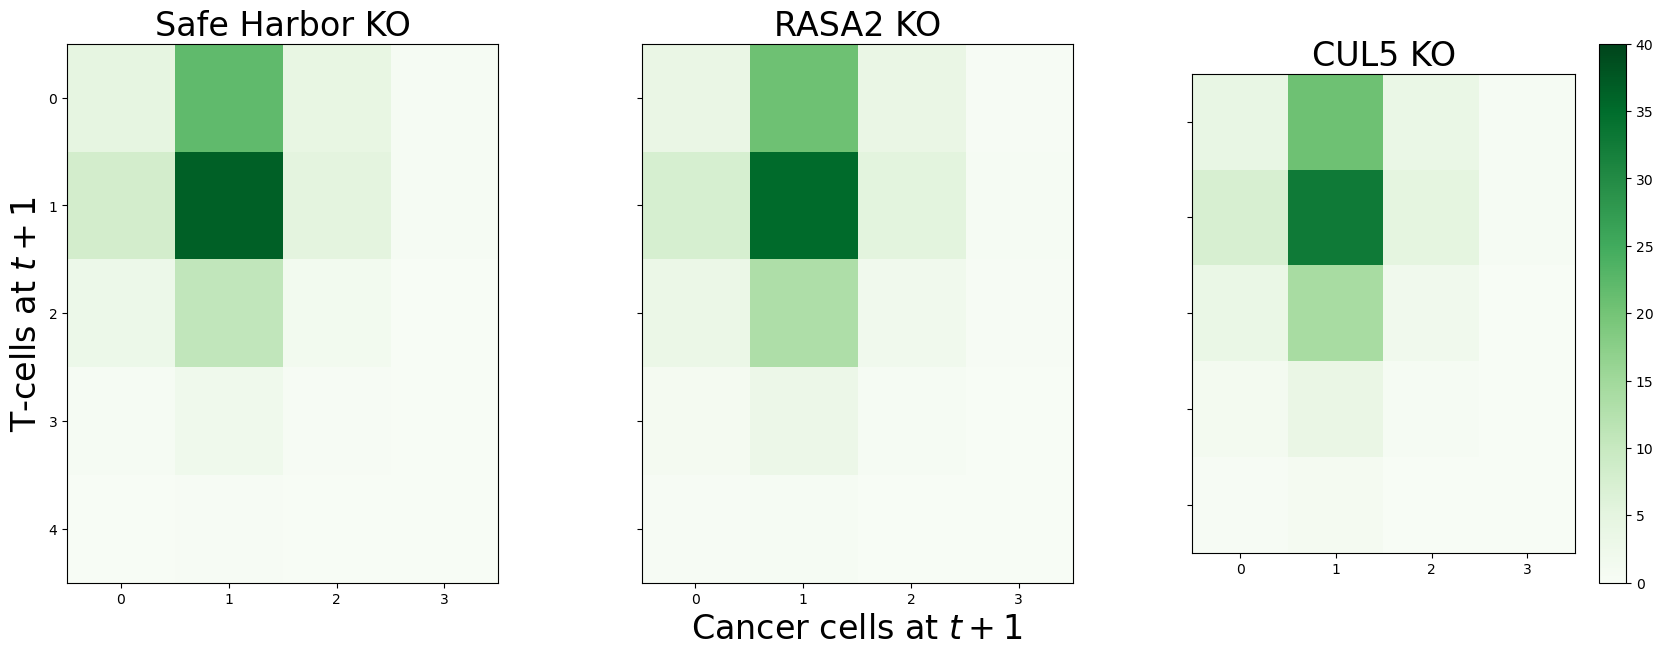

In [15]:
max_t_show = 5
max_c_show = 4

fig, ax = plt.subplots(1,3, sharey = True, figsize = (21,7))
im = ax[0].imshow(100 * norm(sh_1_1)[:max_t_show, :max_c_show], 
             cmap = 'Greens', vmin = 0, vmax = 40)
ax[0].set_title('Safe Harbor KO', fontsize = 24)
ax[1].imshow(100 * norm(rasa_1_1)[:max_t_show, :max_c_show], 
             cmap = 'Greens', vmin = 0, vmax = 40)
ax[1].set_title('RASA2 KO', fontsize = 24)
ax[2].imshow(100 * norm(cul_1_1)[:max_t_show, :max_c_show], 
             cmap = 'Greens', vmin = 0, vmax = 40)
ax[2].set_title('CUL5 KO', fontsize = 24)
ax[0].set_ylabel('T-cells at $t + 1$', fontsize = 24)
ax[1].set_xlabel('Cancer cells at $t + 1$', fontsize = 24)

for i in range(0,3):
    ax[i].set_xticks(np.arange(0, max_c_show))
    
fig.colorbar(im, ax = ax[2]) #, shrink = 0.9)
plt.savefig('./figs/markov_nodiff.svg') #_nocbar.svg')
plt.show()


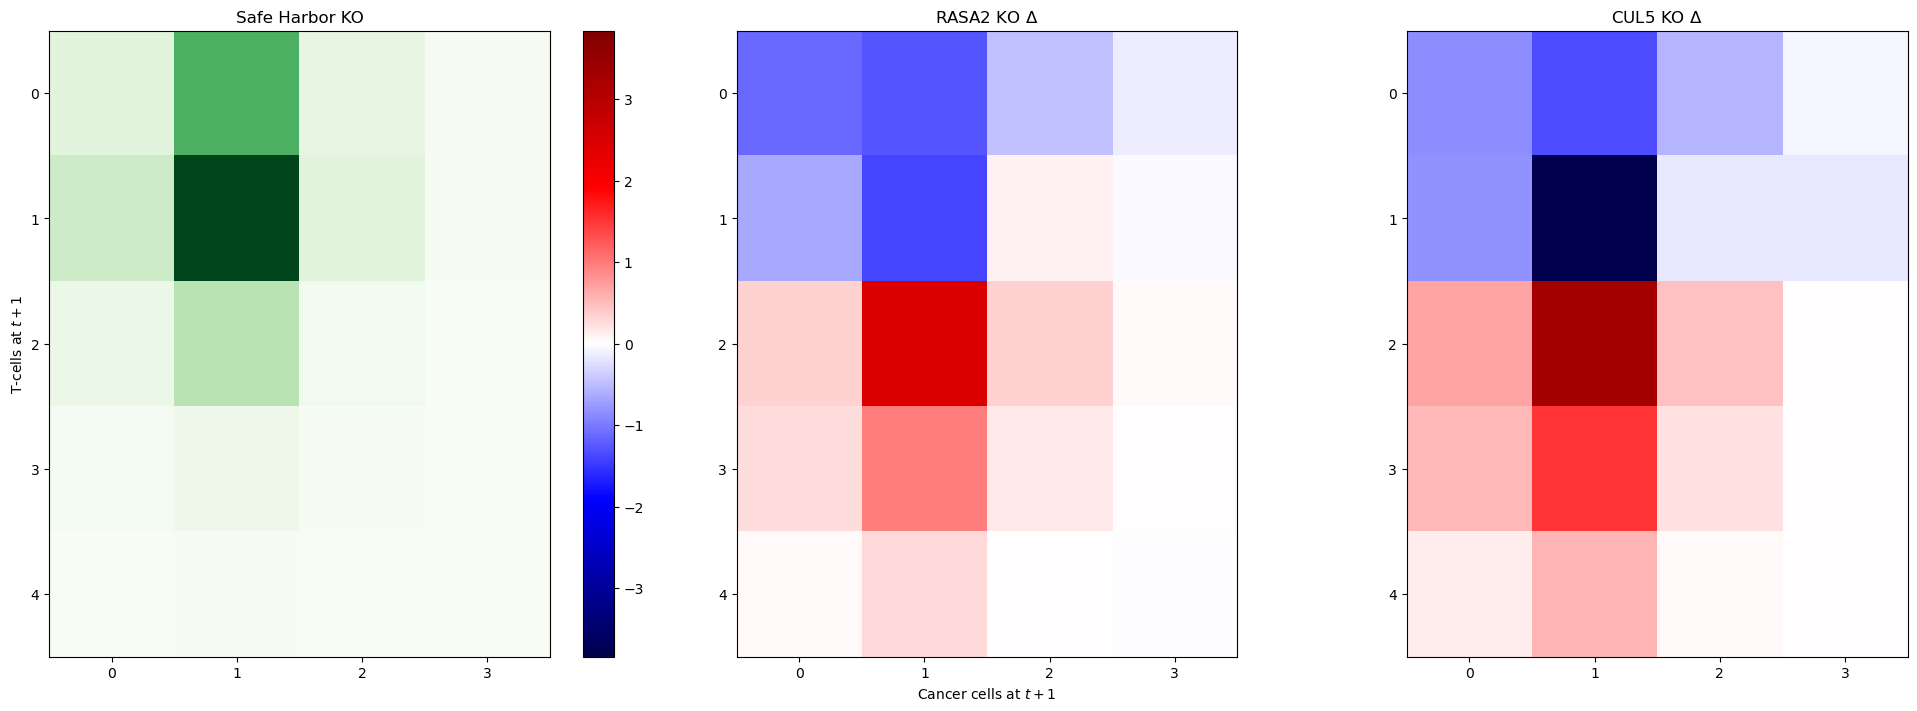

In [16]:
max_t_show = 5
max_c_show = 4

base = norm(sh_1_1)[:max_t_show, :max_c_show]

rasa_plot = norm(rasa_1_1)[:max_t_show, :max_c_show] - base
cul_plot = norm(cul_1_1)[:max_t_show, :max_c_show] - base
vmax = 100 * max(np.max(np.abs(cul_plot)), np.max(np.abs(rasa_plot)))


fig, ax = plt.subplots(1,3, figsize = (21,7), layout = 'constrained')
im0 = ax[0].imshow(100 * norm(sh_1_1)[:max_t_show, :max_c_show], 
             cmap = 'Greens')
#fig.colorbar(im0, ax = ax[0]) #, shrink = 0.9)
ax[0].set_title('Safe Harbor KO')
ax[1].imshow(100 * rasa_plot, 
             cmap = 'seismic', vmin = -vmax, vmax = vmax)
ax[1].set_title('RASA2 KO $\Delta$')
im = ax[2].imshow(100 * cul_plot, 
             cmap = 'seismic', vmin = -vmax, vmax = vmax)
ax[2].set_title('CUL5 KO $\Delta$')
fig.colorbar(im, ax = ax[0]) #, shrink = 0.9)
ax[0].set_ylabel('T-cells at $t + 1$')
ax[1].set_xlabel('Cancer cells at $t + 1$')

for i in range(0,3):
    ax[i].set_xticks(np.arange(0, max_c_show))
    
plt.savefig('./figs/markov_image.pdf')
#plt.show()

In [17]:
from scipy.stats import norm as norm_rv

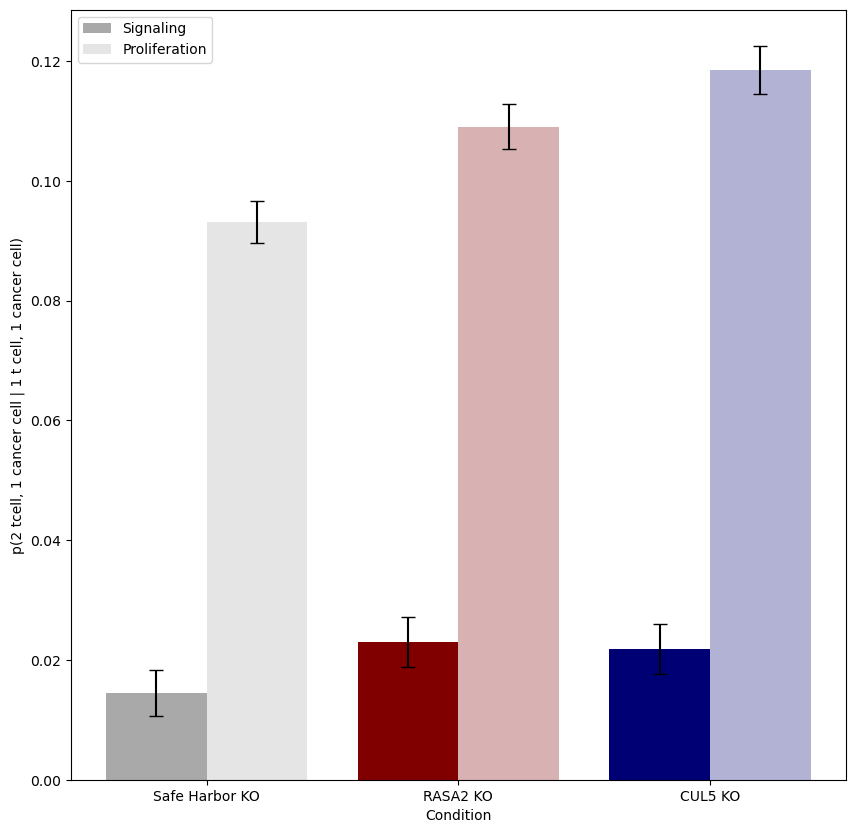

In [18]:
fig, ax = plt.subplots(1,1,figsize = (10,10))

y0 = np.array([norm(sh_1_1)[2,1], norm(rasa_1_1)[2,1], norm(cul_1_1)[2,1]])
pcts = np.array([sh_is_tracked[2,1]/sh_1_1[2,1], rasa_is_tracked[2,1]/rasa_1_1[2,1], cul_is_tracked[2,1]/cul_1_1[2,1]])
n = np.array([np.sum(sh_1_1), np.sum(rasa_1_1), np.sum(cul_1_1)])
yerr = 1.96 * np.sqrt(np.divide(np.multiply(y0, 1 - y0),n))

nbottom = np.array([sh_1_1[2,1], rasa_1_1[2,1], cul_1_1[2,1]])
yerr_bottom = 1.96 * np.sqrt(np.divide(np.multiply(pcts, 1 - pcts),n))
yerr_bottom_plot = np.multiply(yerr_bottom, pcts)


bottom = np.multiply(pcts, y0)
heights = y0 - bottom


ax.bar(np.arange(3) - 0.2, bottom, 
       yerr = yerr_bottom, capsize = 5, width = 0.4,
       color = [colors[i] for i in conditions], label = 'Signaling')
ax.bar(np.arange(3) + 0.2, heights, 
       yerr = yerr, capsize = 5, width = 0.4,
       bottom = 0, color = [colors[i] for i in conditions], alpha = 0.3, label = 'Proliferation')
ax.set_xticks(np.arange(3), conditions)
ax.set_xlabel('Condition')
plt.ylabel('p(2 tcell, 1 cancer cell | 1 t cell, 1 cancer cell)')
plt.legend()
plt.savefig('./figs/markov_signaling_1_to_2_side.pdf')

plt.show()

In [19]:
heights

array([0.0931749 , 0.10901177, 0.11847108])

In [20]:
for i in range(3):
    for j in range(i+1,3):
        print(conditions[i] + ' ' + conditions[j])
        numerator = y0[i] - y0[j]
        denominator = y0[i] * (1 - y0[i])/n[i] + y0[j] * (1 - y0[j])/n[j]
        z = numerator/np.sqrt(denominator)
        print('z: ' + str(z))
        print('p: ' + str(norm_rv.sf(abs(z)) * 2))
        print(' ' )

Safe Harbor KO RASA2 KO
z: -9.317013625591242
p: 1.1966085936416659e-20
 
Safe Harbor KO CUL5 KO
z: -12.08853353487721
p: 1.2143488953722863e-33
 
RASA2 KO CUL5 KO
z: -2.9510636001281667
p: 0.0031668170136472584
 


In [21]:
for i in range(3):
    for j in range(i+1,3):
        print(conditions[i] + ' ' + conditions[j])
        numerator = heights[i] - heights[j]
        denominator = heights[i] * (1 - heights[i])/n[i] + heights[j] * (1 - heights[j])/n[j]
        z = numerator/np.sqrt(denominator)
        print('z: ' + str(z))
        print('p: ' + str(norm_rv.sf(abs(z)) * 2))
        print(' ' )

Safe Harbor KO RASA2 KO
z: -6.504337326156994
p: 7.803661011637753e-11
 
Safe Harbor KO CUL5 KO
z: -10.01986947075611
p: 1.2466748226100879e-23
 
RASA2 KO CUL5 KO
z: -3.6521103417741583
p: 0.0002600940758749022
 


In [22]:
for i in range(3):
    for j in range(i+1,3):
        print(conditions[i] + ' ' + conditions[j])
        numerator = bottom[i] - bottom[j]
        denominator = bottom[i] * (1 - bottom[i])/n[i] + bottom[j] * (1 - bottom[j])/n[j]
        z = numerator/np.sqrt(denominator)
        print('z: ' + str(z))
        print('p: ' + str(norm_rv.sf(abs(z)) * 2))
        print(' ' )

Safe Harbor KO RASA2 KO
z: -7.8546273164056855
p: 4.009625942263286e-15
 
Safe Harbor KO CUL5 KO
z: -6.737604816376996
p: 1.6101878179213865e-11
 
RASA2 KO CUL5 KO
z: 0.9976084634347626
p: 0.31846925547117233
 


In [23]:
y0 = np.array([np.sum(norm(sh_1_1)[:1,]), np.sum(norm(rasa_1_1)[:1,]), np.sum(norm(cul_1_1)[:1,])])
yerr = 1.96 * np.sqrt(np.divide(np.multiply(y0, 1 - y0),n))

In [24]:
for i in range(3):
    for j in range(i+1,3):
        print(conditions[i] + ' ' + conditions[j])
        numerator = y0[i] - y0[j]
        denominator = y0[i] * (1 - y0[i])/n[i] + y0[j] * (1 - y0[j])/n[j]
        z = numerator/np.sqrt(denominator)
        print('z: ' + str(z))
        print('p: ' + str(norm_rv.sf(abs(z)) * 2))
        print(' ' )

Safe Harbor KO RASA2 KO
z: 8.108206711708792
p: 5.137228842027778e-16
 
Safe Harbor KO CUL5 KO
z: 7.4216800110960826
p: 1.1564393910064586e-13
 
RASA2 KO CUL5 KO
z: -0.5712368176018635
p: 0.5678391240931113
 


## Calculate dwell time as negative binomial mean + 8 minutes given for calling an interaction

In [25]:
y0

array([0.31169734, 0.28176689, 0.28386478])

In [26]:
yerr

array([0.00522303, 0.00500666, 0.00517178])

In [27]:
4 * (1 - y0)/y0 + 8

array([16.83296167, 18.19613228, 18.09121622])

In [28]:
markov_dwell = 8 + np.array([8.83296167, 10.19613228, 10.09121622])

In [29]:
upper = 8 + 4 * (1 - (y0 + yerr))/(y0 + yerr)
lower = 8 + 4 * (1 - (y0 - yerr))/(y0 - yerr)

In [30]:
upper

array([16.62146703, 17.94828805, 17.8390796 ])

In [31]:
markov_dwell

array([16.83296167, 18.19613228, 18.09121622])

In [32]:
lower

array([17.05166501, 18.45294364, 18.35271077])